In [63]:
using Revise

In [64]:
using PyCall, PyPlot, Statistics
inset_locator = pyimport("mpl_toolkits.axes_grid.inset_locator");
mpl = pyimport("matplotlib");
mpl.rcParams["lines.linewidth"] = 2;

In [65]:
using ClimateMARGO
using ClimateMARGO.Models
using ClimateMARGO.Diagnostics
using ClimateMARGO.Optimization
using ClimateMARGO.Plotting

## Make figures from default model configuration for manuscript

#### Approach 1: Cost-benefit analysis

In [66]:
model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]))
@time optimize_controls!(model, obj_option = "net_benefit");

Solve_Succeeded
  0.053629 seconds (92.79 k allocations: 3.866 MiB)


In [67]:
stat_dict = Dict("mitigate" => [], "remove" => [], "geoeng" => [], "adapt" => [], "maxgeoeng" => [], "maxTnoG" => [], "maxT" => [], "maxCO2" => [])
ρdict = Dict()
ρs = 0.:0.0025:0.075

for ρ in ρs
    tmp_model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]));
    tmp_model.economics.ρ = ρ
    @time optimize_controls!(tmp_model, obj_option = "net_benefit");
    ρdict[ρ] = tmp_model
    
    append!(stat_dict["mitigate"], mean(tmp_model.controls.mitigate[model.economics.baseline_emissions .> 0.]))
    append!(stat_dict["remove"], mean(tmp_model.controls.remove))
    append!(stat_dict["adapt"], mean(tmp_model.controls.adapt))
    append!(stat_dict["geoeng"], mean(tmp_model.controls.geoeng))
    append!(stat_dict["maxTnoG"], maximum(T(tmp_model, M=true, R=true)))
    append!(stat_dict["maxT"], maximum(T(tmp_model, M=true, R=true, G=true)))
    append!(stat_dict["maxCO2"], maximum(c(tmp_model, M=true, R=true)))
end

Solve_Succeeded
  0.064533 seconds (110.24 k allocations: 4.205 MiB)
Solve_Succeeded
  0.058067 seconds (101.52 k allocations: 4.035 MiB)
Solve_Succeeded
  0.072270 seconds (114.72 k allocations: 4.299 MiB)
Solve_Succeeded
  0.067462 seconds (110.24 k allocations: 4.205 MiB)
Solve_Succeeded
  0.058944 seconds (106.00 k allocations: 4.130 MiB)
Solve_Succeeded
  0.064367 seconds (105.88 k allocations: 4.120 MiB)
Solve_Succeeded
  0.059371 seconds (97.28 k allocations: 3.961 MiB)
Solve_Succeeded
  0.058847 seconds (101.52 k allocations: 4.035 MiB)
Solve_Succeeded
  0.051134 seconds (92.92 k allocations: 3.876 MiB)
Solve_Succeeded
  0.050487 seconds (88.43 k allocations: 3.781 MiB)
Solve_Succeeded
  0.045663 seconds (84.07 k allocations: 3.697 MiB)
Solve_Succeeded
  0.046806 seconds (84.19 k allocations: 3.707 MiB)
Solve_Succeeded
  0.045100 seconds (79.71 k allocations: 3.612 MiB)
Solve_Succeeded
  0.042528 seconds (79.71 k allocations: 3.612 MiB)
Solve_Succeeded
  0.046641 seconds (84.19

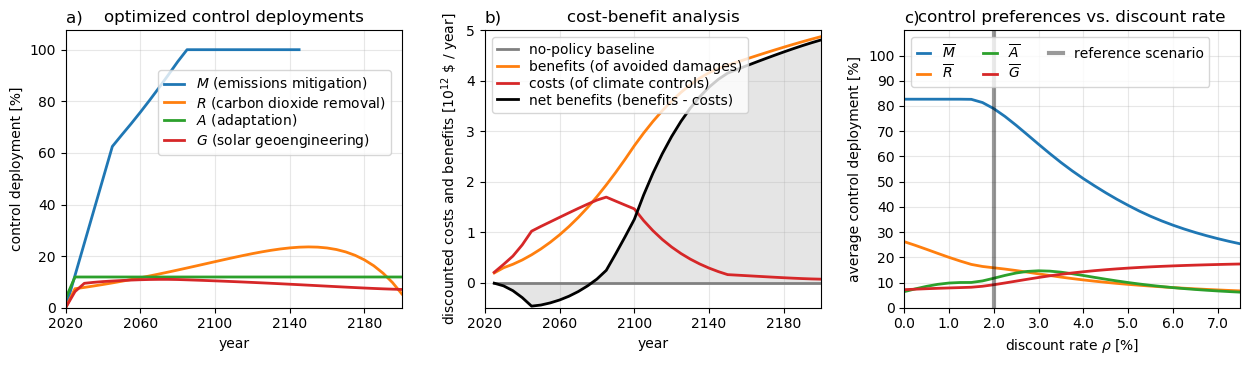

Maximum warming: 1.186373185757678

In [68]:
fig = figure(figsize=(12.75,3.75))

fig.add_subplot(1,3,1)
plot_controls(model)
legend(handlelength=1.5, loc=(0.275, 0.55), labelspacing=0.1)
title("a)", loc="left")

ax = fig.add_subplot(1,3,2)
plot_benefits(model, discounting=true)
legend(handlelength=1.5, loc="upper left", labelspacing=0.2)
title("b)", loc="left")
ylim([-0.5, 5.])

ax = fig.add_subplot(1,3,3)
plot(ρs, stat_dict["mitigate"], lw=2, label=L"$\overline{M}$")
plot(ρs, stat_dict["remove"], lw=2, label=L"$\overline{R}$")
plot(ρs, stat_dict["adapt"], lw=2, label=L"$\overline{A}$")
plot(ρs, stat_dict["geoeng"], lw=2, label=L"$\overline{G}$")
axvline(model.economics.ρ, color="k", label="reference scenario", alpha=0.4, lw=3)
legend(ncol=3, handlelength=1., labelspacing=0.14, loc="upper left")
ylim([0, 1.1])
xlim([0., 0.075])
xticks(0:0.01:0.075, 0:1:7.5)
yticks(0:0.1:1, 0:10:100)
grid(true, alpha=0.3)
ylabel("average control deployment [%]")
title("control preferences vs. discount rate")
title("c)", loc="left")
xlabel(L"discount rate $\rho$ [%]")

tight_layout()
savefig("figures/default-benefits_controls_and_benefits.png", dpi=200, bbox_inches="tight")

print("Maximum warming: ", maximum(T(model, M=true, R=true, G=true, A=true)))

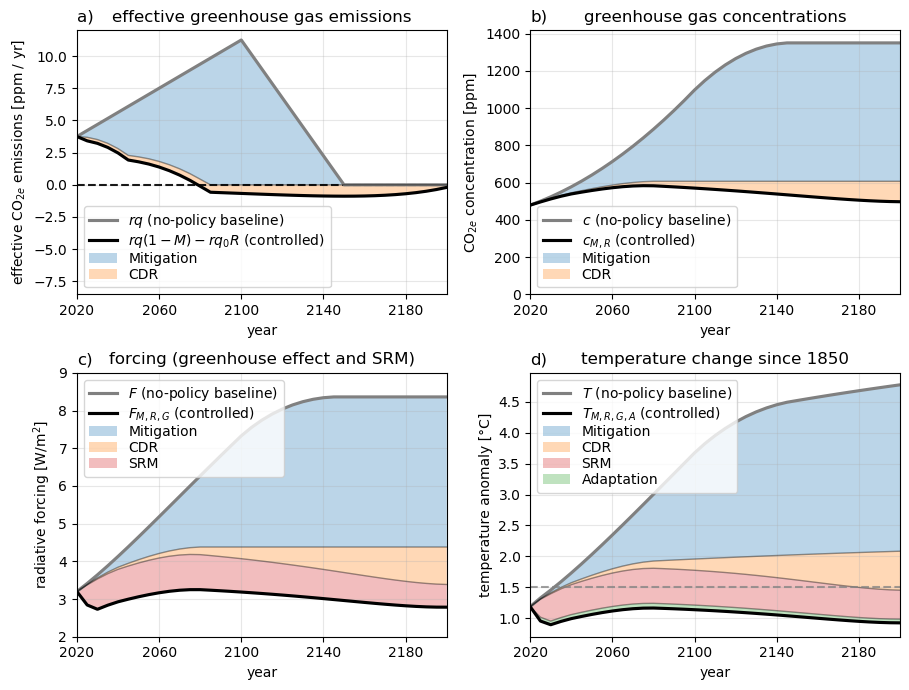

In [69]:
figure(figsize=(9.2,7))

subplot(2,2,1)
plot_emissions(model)
legend(loc="lower left", labelspacing=0.14)
title("a)", loc="left")
ylim(-8.5, 12)
subplot(2,2,2)
plot_concentrations(model)
legend(loc="lower left", labelspacing=0.14)
title("b)", loc="left")
subplot(2,2,3)
plot_forcings(model)
legend(loc="upper left", labelspacing=0.14)
title("c)", loc="left")
ylim(2, 9)
tight_layout()
subplot(2,2,4)
plot_temperatures(model)
legend(loc="upper left", labelspacing=0.14)
title("d)", loc="left")
tight_layout()
savefig("figures/SI_default-temp_carbon_and_temperatures_cost-benefit.png", dpi=200, bbox_inches="tight")

In [70]:
model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]))
model.economics.ρ = 0.075
@time optimize_controls!(model, obj_option = "net_benefit");

Solve_Succeeded
  0.060754 seconds (101.52 k allocations: 4.035 MiB)


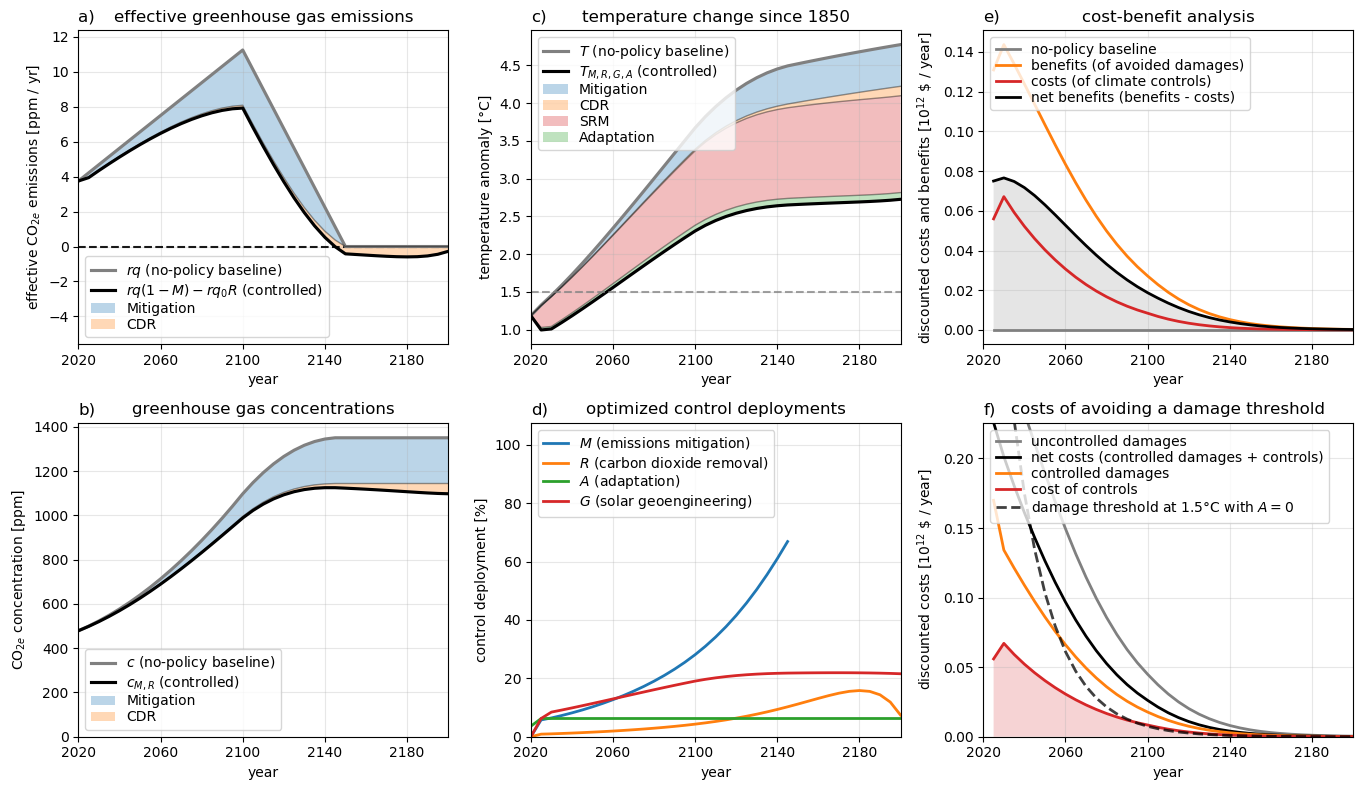

(Figure(PyObject <Figure size 1400x800 with 6 Axes>), PyObject[PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7ff68e688f98>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7ff689a8ca20>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7ff68dea53c8>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7ff68cfe5b38>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7ff68c9880f0>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7ff689b1a550>])

In [71]:
plot_state(model)

#### Approach 2: Avoiding damage thresholds

In [72]:
model = ClimateModel(ClimateMARGO.IO.included_configurations["default"])
@time optimize_controls!(model);

Solve_Succeeded
  0.074122 seconds (111.97 k allocations: 4.545 MiB)


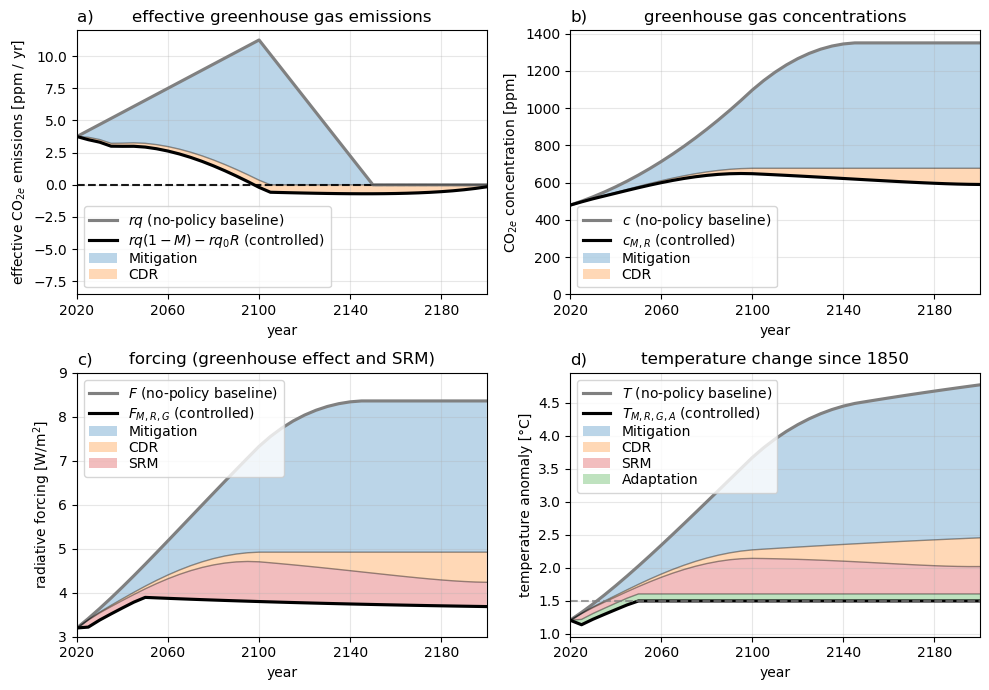

In [73]:
figure(figsize=(10,7))

subplot(2,2,1)
plot_emissions(model)
legend(loc="lower left", labelspacing=0.14)
title("a)", loc="left")
ylim(-8.5, 12)
subplot(2,2,2)
plot_concentrations(model)
legend(loc="lower left", labelspacing=0.14)
title("b)", loc="left")
subplot(2,2,3)
plot_forcings(model)
legend(loc="upper left", labelspacing=0.14)
title("c)", loc="left")
ylim(3, 9)
tight_layout()
subplot(2,2,4)
plot_temperatures(model)
legend(loc="upper left", labelspacing=0.14)
title("d)", loc="left")
tight_layout()
savefig("figures/default-temp_carbon_and_temperatures.png", dpi=200, bbox_inches="tight")

In [40]:
base_model = deepcopy(ClimateModel(ClimateMARGO.IO.included_configurations["default"]));

ρs = 0.:0.001:0.05
CGs = 0.:0.004:0.20;
models = Array{ClimateModel}(undef, size(ρs,1), size(CGs,1));

for (i, ρ) in enumerate(ρs)
    for (j, CG) in enumerate(CGs)
        tmp = deepcopy(base_model)
        tmp.economics.ρ = ρ
        tmp.economics.geoeng_cost = CG
        optimize_controls!(tmp, print_raw_status=false)
        models[i, j] = tmp
    end
end

GFmax = Array{Float64}(undef, size(ρs,1), size(CGs,1));
for (i, ρ) in enumerate(ρs)
    for (j, CG) in enumerate(CGs)
        GFmax[i,j] = maximum(F(models[i,j], M=true, R=true) - F(models[i,j], M=true, R=true, G=true))
    end
end

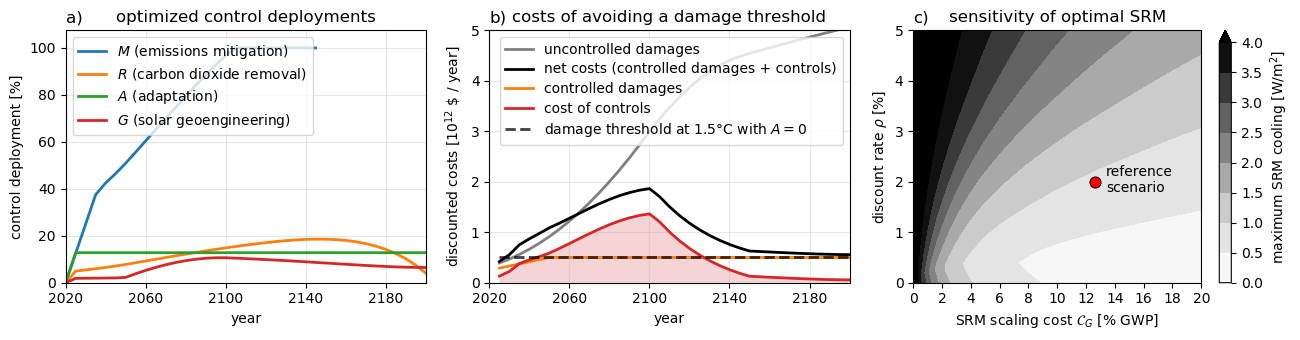

Net Present Control Costs = 97.35800549211515 trillion USD

In [41]:
figure(figsize=(13.2,3.5))

subplot(1,3,1)
plot_controls(model)
legend(loc="upper left", labelspacing=0.4)
title("a)", loc="left")

subplot(1,3,2)
plot_damages(model)
legend(loc="upper right", labelspacing=0.4)
title("b)", loc="left")
ylim([0, 5])

subplot(1,3,3)
GFlev = 0.:0.5:4
contourf(CGs, ρs, GFmax, cmap="Greys", levels=GFlev, extend="max")
colorbar(label = L"maximum SRM cooling [W/m$^{2}$]", ticks=GFlev)
plot([base_model.economics.geoeng_cost], [base_model.economics.ρ], "ro", label="reference scenario", markeredgecolor="k", markersize=8, markeredgewidth=0.7)
annotate("reference\nscenario", (base_model.economics.geoeng_cost + 0.008, base_model.economics.ρ - 0.0021))
yticks(0.:0.01:0.05, 0:1:5)
xticks(0.:0.02:0.2, 0:2:20)
xlabel(L"SRM scaling cost $\mathcal{C}_{G}$ [% GWP]")
ylabel(L"discount rate $\rho$ [%]")
title("sensitivity of optimal SRM")
title("c)", loc="left")

tight_layout()
savefig("figures/default-temp_controls_and_damages.png", dpi=200, bbox_inches="tight")

print("Net Present Control Costs = ", net_present_cost(model, M=true, R=true, G=true, A=true), " trillion USD")